In [1]:
!apt-get update && apt-get install -y libgl1
!pip install opencv-python-headless
!pip install numpy pandas matplotlib decord scipy pillow
!pip install moviepy==1.0.3
!pip install seaborn

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Fetched 128 kB in 6s (20.1 kB/s)                                               
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1 is already the newest version (1.4.0-1).
0 upgraded, 0 newly installed, 0 to remove and 128 not upgraded.
  Obtaining dependency information for numpy<2.3.0,>=2 from https://files.pythonhosted.org/packages/b4/63/3de6a34ad7ad6646ac7d2f55ebc6ad439dbbf9c4370017c50cf403fb19b5/numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_

In [2]:
import os
import csv

base_dir = '/home/jovyan/CREMA-D-SPLIT'
splits = ['train', 'val', 'test']

emotion_mapping = {
    "anger":    (-0.6, 0.8),
    "disgust":  (-0.6, 0.6),
    "fear":     (-0.6, 0.9),
    "happiness":(0.8, 0.7),
    "sadness":  (-0.7, -0.4)
}

output_csv = '/home/jovyan/CREMA_D_annotations.csv'

with open(output_csv, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['expected_filename', 'dominant_emotion', 'Adjusted_Arousal', 'Adjusted_Valence'])
    
    for split in splits:
        split_dir = os.path.join(base_dir, split)
        for file in os.listdir(split_dir):
            if file.endswith('.mp4'):
                # Example filename: 1001_disgust-XX_10.mp4
                try:
                    parts = file.split('_')
                    emotion_part = parts[1]  # 'disgust-XX' or 'fear-LO' etc.
                    emotion = emotion_part.split('-')[0]
                    
                    if emotion not in emotion_mapping:
                        print(f"Skipping unknown emotion in file: {file}")
                        continue
                    
                    arousal, valence = emotion_mapping[emotion]
                    writer.writerow([file, emotion, arousal, valence])
                except Exception as e:
                    print(f"Error processing {file}: {e}")


In [2]:
import pandas as pd
import os
import warnings
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from decord import VideoReader
from sklearn.model_selection import train_test_split # Still useful if you want to re-split or verify

# Suppress warnings
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Configure GPU if available
device_name = tf.config.list_physical_devices('GPU')
if device_name:
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    for pd_ in device_name:
        tf.config.experimental.set_memory_growth(pd_, True)
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.get_strategy()


input_size = 224
num_frame = 16
batch_size = 16 * strategy.num_replicas_in_sync


# Base path to the dataset folders and CSV file
base_data_path = "/home/jovyan/CREMA-D-SPLIT"  # This is the directory containing train, val, test subfolders
output_csv_path = "/home/jovyan/CREMA_D_annotations.csv"
model_path = "/home/jovyan/model"  # Updated model path

def is_video_valid(file_path):
    """Checks if a video file exists and can be opened by VideoReader."""
    if not os.path.exists(file_path):
        return False
    try:
        vr = VideoReader(file_path)
        return len(vr) > 0
    except Exception as e:
        # print(f"Error opening video {file_path}: {e}") # Uncomment for more detailed errors
        return False

def build_dataframes_from_folders(csv_path, base_data_folder):
    """
    Builds separate DataFrames for train, val, and test by scanning
    the respective subfolders and matching with the CSV labels.
    """
    full_labels_df = pd.read_csv(csv_path)

    train_data = []
    val_data = []
    test_data = []

    # Iterate through the subfolders (train, val, test)
    for subfolder in ['train', 'val', 'test']:
        current_folder_path = os.path.join(base_data_folder, subfolder)
        if not os.path.isdir(current_folder_path):
            print(f"Warning: Subfolder '{subfolder}' not found at {current_folder_path}. Skipping.")
            continue

        print(f"Processing videos in: {current_folder_path}")
        # Get all video files in the current subfolder
        for filename in os.listdir(current_folder_path):
            if filename.endswith((".mp4", ".avi", ".mov", ".mkv")): # Add other video extensions if needed
                full_video_path = os.path.join(current_folder_path, filename)

                # Find the corresponding label in the full_labels_df using the original filename
                # We need to use the original filename (e.g., s9_fear_1_sequential.mp4) to match the CSV
                matching_row = full_labels_df[full_labels_df['expected_filename'] == filename]

                if not matching_row.empty:
                    if is_video_valid(full_video_path):
                        valence = matching_row['Adjusted_Valence'].iloc[0]
                        arousal = matching_row['Adjusted_Arousal'].iloc[0]
                        
                        record = {
                            'video_path': os.path.abspath(full_video_path),
                            'valence': valence,
                            'arousal': arousal
                        }
                        
                        if subfolder == 'train':
                            train_data.append(record)
                        elif subfolder == 'val':
                            val_data.append(record)
                        elif subfolder == 'test':
                            test_data.append(record)
                    else:
                        print(f"Skipping invalid video: {full_video_path}")
                # else: # Uncomment if you want to see videos in folders but not in CSV
                #     print(f"Warning: Video {filename} in {subfolder} not found in CSV labels.")

    train_df = pd.DataFrame(train_data).sample(frac=1).reset_index(drop=True)
    val_df = pd.DataFrame(val_data).sample(frac=1).reset_index(drop=True)
    test_df = pd.DataFrame(test_data).sample(frac=1).reset_index(drop=True)

    return train_df, val_df, test_df


# Load train, val, test dataframes by scanning folders
train_df, val_df, test_df = build_dataframes_from_folders(output_csv_path, base_data_path)

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# --- The rest of your code remains largely the same ---

# Video reading and formatting functions
def read_video(file_path):
    file_path = file_path.numpy().decode('utf-8')
    vr = VideoReader(file_path)
    total_frames = len(vr)
    frame_indices = np.linspace(0, total_frames - 1, num_frame, dtype=np.int32)
    frame_indices = np.clip(frame_indices, 0, total_frames - 1)
    frames = vr.get_batch(frame_indices).asnumpy()
    return format_frames(frames, output_size=(input_size, input_size))

def format_frames(frames, output_size):
    frames = tf.image.convert_image_dtype(frames, tf.float32)
    frames = tf.image.resize(frames, size=list(output_size))
    return frames

def load_video(file_path, valence, arousal):
    video = tf.py_function(func=read_video, inp=[file_path], Tout=tf.float32)
    video.set_shape([num_frame, input_size, input_size, 3])
    label = tf.stack([valence, arousal])
    return video, label

def create_dataloader(df, batch_size, shuffle=True, drop_reminder=True):
    paths = df['video_path'].values
    valences = df['valence'].values.astype(np.float32)
    arousals = df['arousal'].values.astype(np.float32)
    
    ds = tf.data.Dataset.from_tensor_slices((paths, valences, arousals))
    if shuffle:
        ds = ds.shuffle(8 * batch_size)
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=drop_reminder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataloader(train_df, batch_size, shuffle=True)
val_ds = create_dataloader(val_df, batch_size, shuffle=False)
test_ds = create_dataloader(test_df, batch_size, shuffle=False)

# Load pretrained model
pretrained_model = tf.saved_model.load(model_path)

class TFSMLayer(tf.keras.layers.Layer):
    def __init__(self, model):
        super(TFSMLayer, self).__init__()
        self.model = model

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        return self.model.signatures['serving_default'](input_1=inputs)['output_1']

# Concordance Correlation Coefficient (CCC) metric
def concordance_cc(y_true, y_pred):
    true_mean = tf.reduce_mean(y_true, axis=0)
    pred_mean = tf.reduce_mean(y_pred, axis=0)
    cov = tf.reduce_mean((y_true - true_mean) * (y_pred - pred_mean), axis=0)
    true_var = tf.reduce_mean(tf.square(y_true - true_mean), axis=0)
    pred_var = tf.reduce_mean(tf.square(y_pred - pred_mean), axis=0)
    ccc = (2 * cov) / (true_var + pred_var + tf.square(true_mean - pred_mean) + 1e-8)
    return tf.reduce_mean(ccc)

# Optional CCC loss
def ccc_loss(y_true, y_pred):
    return 1 - concordance_cc(y_true, y_pred)

# Build regression model and compile
with strategy.scope():
    inputs = layers.Input(shape=(num_frame, input_size, input_size, 3))
    x = TFSMLayer(pretrained_model)(inputs)
    outputs = layers.Dense(2, dtype='float32')(x)  # valence & arousal
    model = keras.Model(inputs=inputs, outputs=outputs, name="valence_arousal_regressor")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=ccc_loss,  # Using CCC loss as per your last compilation block
        metrics=[
            keras.metrics.MeanAbsoluteError(name='mae'),
            tf.keras.metrics.MeanMetricWrapper(concordance_cc, name='ccc')
        ]
    )

model.summary()

# Learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-5
)

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=len(train_df) // batch_size,
    validation_steps=len(val_df) // batch_size,
    epochs=50,
    verbose=1,
    callbacks=[lr_scheduler]
)

# After training, evaluate on test set
print("-------\nEvaluating on test set...\n")
test_results = model.evaluate(test_ds, steps=len(test_df) // batch_size, verbose=1)
print(f"\nTest Loss: {test_results[0]:.4f}")
print(f"Test MAE: {test_results[1]:.4f}")
print(f"Test CCC: {test_results[2]:.4f}")

2025-07-20 18:55:21.051350: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100-SXM4-40GB MIG 3g.20gb, compute capability 8.0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2025-07-20 18:55:23.709876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17947 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:07:00.0, compute capability: 8.0


Processing videos in: /home/jovyan/CREMA-D-SPLIT/train
Processing videos in: /home/jovyan/CREMA-D-SPLIT/val
Processing videos in: /home/jovyan/CREMA-D-SPLIT/test
Train samples: 1025
Validation samples: 341
Test samples: 347
Model: "valence_arousal_regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 224, 224, 3   0         
                             )]                                  
                                                                 
 tfsm_layer (TFSMLayer)      (None, 400)               0         
                                                                 
 dense (Dense)               (None, 2)                 802       
                                                                 
Total params: 802 (3.13 KB)
Trainable params: 802 (3.13 KB)
Non-trainable params: 0 (0.00 Byte)
___________________________________________________

2025-07-20 18:55:42.944388: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_3"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1025
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

Epoch 1/50
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens

2025-07-20 18:55:53.540286: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563413017ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-20 18:55:53.540336: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 3g.20gb, Compute Capability 8.0
2025-07-20 18:55:54.133462: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-20 18:56:00.230042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2025-07-20 18:56:19.340053: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


64/64 [==============================] - ETA: 0s - loss: 0.8583 - mae: 0.6113 - ccc: 0.1417

2025-07-20 18:57:37.632121: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_3"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 341
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:5"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRO

64/64 [==============================] - 157s 2s/step - loss: 0.8583 - mae: 0.6113 - ccc: 0.1417 - val_loss: 0.8076 - val_mae: 0.4715 - val_ccc: 0.1924 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 125s 2s/step - loss: 0.6837 - mae: 0.4239 - ccc: 0.3163 - val_loss: 0.7386 - val_mae: 0.4549 - val_ccc: 0.2614 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 126s 2s/step - loss: 0.6210 - mae: 0.3969 - ccc: 0.3790 - val_loss: 0.6638 - val_mae: 0.4107 - val_ccc: 0.3362 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 116s 2s/step - loss: 0.5720 - mae: 0.3868 - ccc: 0.4280 - val_loss: 0.6568 - val_mae: 0.4355 - val_ccc: 0.3432 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 121s 2s/step - loss: 0.5417 - mae: 0.3820 - ccc: 0.4583 - val_loss: 0.6376 - val_mae: 0.4274 - val_ccc: 0.3624 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 115s 2s/step - loss: 0.5218 - mae: 0.3747 - ccc: 0.4782 - val_loss: 0.6182 - va

2025-07-20 20:31:47.144434: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_3"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 347
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:9"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRO

21/21 [==============================] - 29s 1s/step - loss: 0.4756 - mae: 0.3714 - ccc: 0.5244

Test Loss: 0.4756
Test MAE: 0.3714
Test CCC: 0.5244


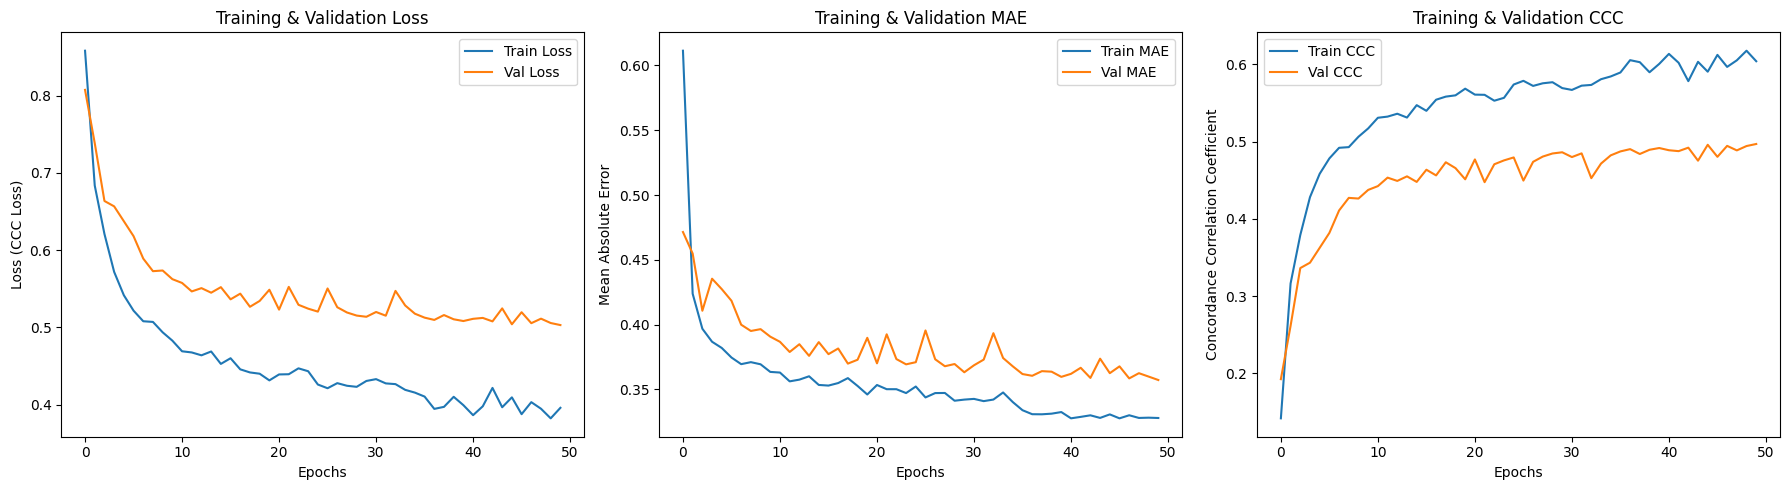

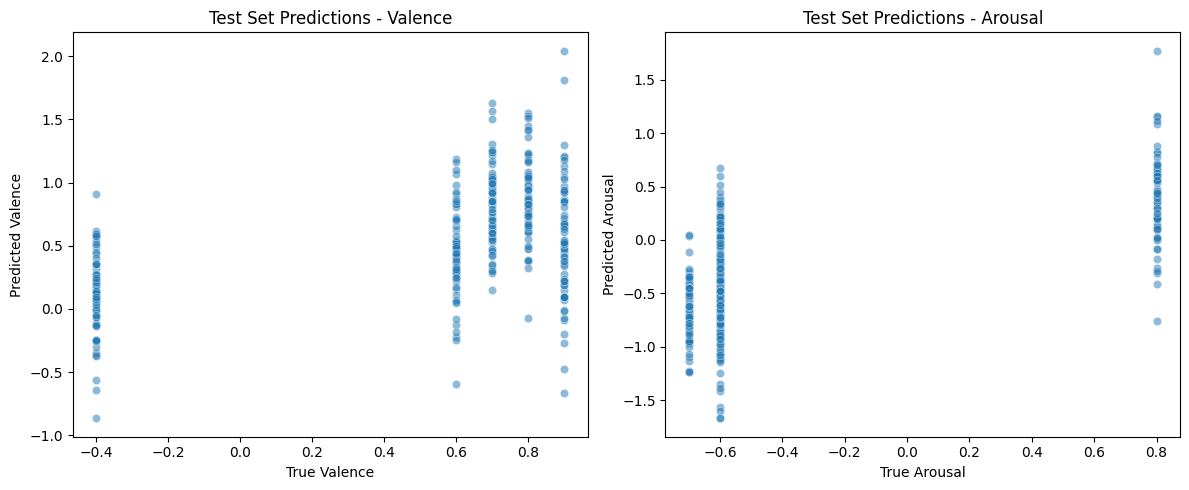

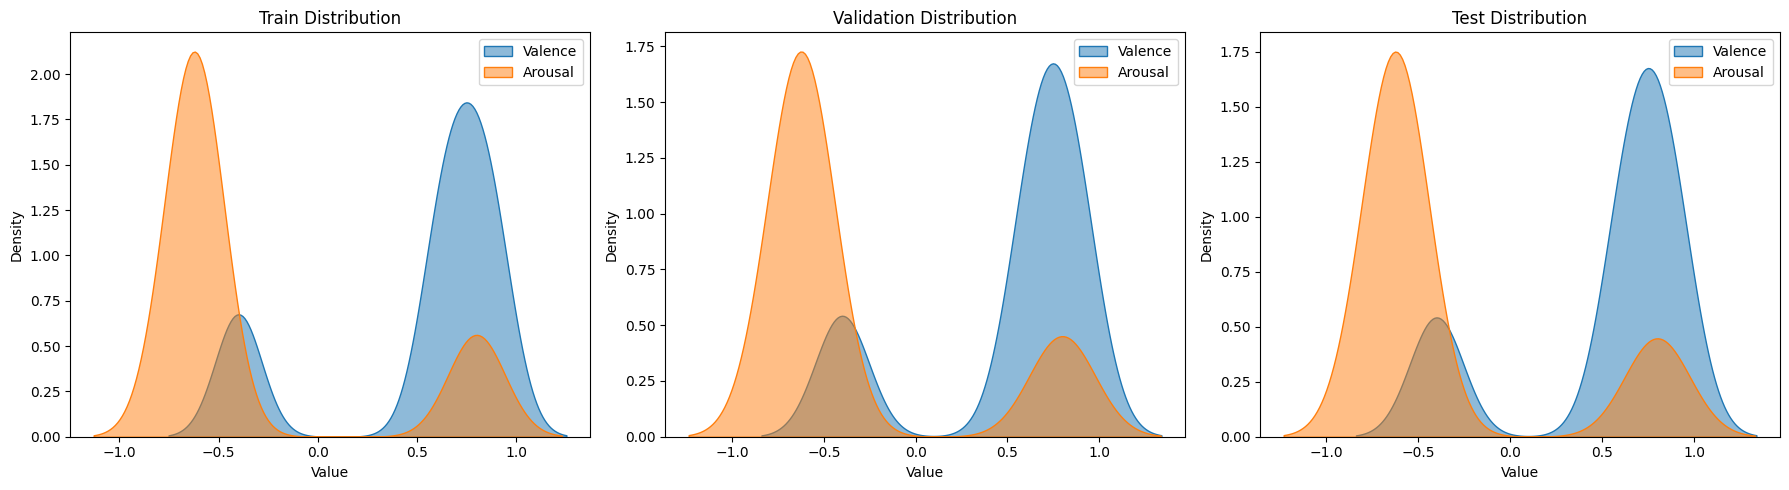

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot training history
def plot_training_history(history):
    history_dict = history.history

    plt.figure(figsize=(18, 5))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(history_dict['loss'], label='Train Loss')
    plt.plot(history_dict['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (CCC Loss)')
    plt.title('Training & Validation Loss')
    plt.legend()

    # MAE
    plt.subplot(1, 3, 2)
    plt.plot(history_dict['mae'], label='Train MAE')
    plt.plot(history_dict['val_mae'], label='Val MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title('Training & Validation MAE')
    plt.legend()

    # CCC
    plt.subplot(1, 3, 3)
    plt.plot(history_dict['ccc'], label='Train CCC')
    plt.plot(history_dict['val_ccc'], label='Val CCC')
    plt.xlabel('Epochs')
    plt.ylabel('Concordance Correlation Coefficient')
    plt.title('Training & Validation CCC')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to plot prediction vs ground truth
def plot_predictions(model, dataset, title="Test Set Predictions"):
    y_true_list = []
    y_pred_list = []

    for x_batch, y_batch in dataset:
        preds = model.predict(x_batch, verbose=0)
        y_true_list.append(y_batch.numpy())
        y_pred_list.append(preds)

    y_true = np.concatenate(y_true_list, axis=0)
    y_pred = np.concatenate(y_pred_list, axis=0)

    plt.figure(figsize=(12, 5))

    # Valence
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_true[:, 0], y=y_pred[:, 0], alpha=0.5)
    plt.xlabel("True Valence")
    plt.ylabel("Predicted Valence")
    plt.title(f"{title} - Valence")

    # Arousal
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_true[:, 1], y=y_pred[:, 1], alpha=0.5)
    plt.xlabel("True Arousal")
    plt.ylabel("Predicted Arousal")
    plt.title(f"{title} - Arousal")

    plt.tight_layout()
    plt.show()

# Function to plot label distributions
def plot_label_distributions(train_df, val_df, test_df):
    plt.figure(figsize=(18, 5))

    datasets = [train_df, val_df, test_df]
    titles = ['Train', 'Validation', 'Test']

    for i, df in enumerate(datasets):
        plt.subplot(1, 3, i+1)
        sns.kdeplot(df['valence'], label='Valence', fill=True, alpha=0.5)
        sns.kdeplot(df['arousal'], label='Arousal', fill=True, alpha=0.5)
        plt.title(f'{titles[i]} Distribution')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()

    plt.tight_layout()
    plt.show()

# --------- Run Visualizations ---------

# 1. Plot training history
plot_training_history(history)

# 2. Plot predictions vs ground truth for test set
plot_predictions(model, test_ds, title="Test Set Predictions")

# 3. Plot valence & arousal distributions in splits
plot_label_distributions(train_df, val_df, test_df)
